<small><font color=gray>Авторы ноутбука: Олег Мельников, Кирилл Быков, Алексей Болдырев, Максим Карпов, Юрий Саночкин ©2025 </font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🪐Venus+Mars</font>](https://www.kaggle.com/t/f21cb382437d478b833c0e745987e3d2)**.

In [1]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
pip install -U kaggle  # upgrade пакет kaggle (чтобы избежать предупреждения)

In [3]:
!mkdir -p ~/.kaggle                               # папка .kaggle должна содержать kaggle.json для исполняемого файла kaggle, чтобы правильно аутентифицировать вас в Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json  # Сначала загрузите kaggle.json из kaggle.com (на странице учетной записи) и поместите его в корень подключенного Google Диска
!chmod 600 ~/.kaggle/kaggle.json                  # предоставить только владельцу полный доступ для чтения/записи к файлу kaggle.json
!kaggle config set -n competition -v june-25-hse-venus-mars # установите контекст конкурса для следующих нескольких вызовов API kaggle. !kaggle config view - отображает текущие настройки
!kaggle competitions download                     # загрузите набор данных соревнования в виде zip-файла
!unzip -o *.zip                                   # набор данных с kaggle копируется в виде единого файла, который необходимо распаковать
!kaggle competitions leaderboard --show           # напечатать public leaderboard

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/female/fx10380.jpg  
  inflating: train/female/fx103b1.jpg  
  inflating: train/female/fx103c4.jpg  
  inflating: train/female/fx103eb.jpg  
  inflating: train/female/fx103ee.jpg  
  inflating: train/female/fx104cf.jpg  
  inflating: train/female/fx104d6.jpg  
  inflating: train/female/fx104d7.jpg  
  inflating: train/female/fx104dd.jpg  
  inflating: train/female/fx1051d.jpg  
  inflating: train/female/fx1055d.jpg  
  inflating: train/female/fx105b2.jpg  
  inflating: train/female/fx105b9.jpg  
  inflating: train/female/fx105e7.jpg  
  inflating: train/female/fx105f1.jpg  
  inflating: train/female/fx10637.jpg  
  inflating: train/female/fx10675.jpg  
  inflating: train/female/fx1067f.jpg  
  inflating: train/female/fx10685.jpg  
  inflating: train/female/fx1068f.jpg  
  inflating: train/female/fx106c4.jpg  
  inflating: train/female/fx10742.jpg  
  inflating: train/female/fx10826.jpg  
  inflating:

Смотрите [больше](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) про NVIDIA GPU статистику. Тестируйте свой код в бесплатном Colab. В нем используется графический процессор Tesla T4 или TPU v2-8.

In [4]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15095 MiB, 0 MiB


In [5]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
from torch.utils.data import random_split
import torch, torchvision
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Sequential, Flatten, Linear, LazyLinear, Dropout, AdaptiveAvgPool2d, MaxPool2d, Conv2d, AvgPool2d
import torchvision
from torchvision.models import resnet50, mobilenet_v2, mobilenet_v3_small
from torchvision.datasets import ImageFolder
import torchvision.transforms as v2
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # округляет значения до 2 знаков после точки

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ начался. У вас есть {lim} сек. Удачи!')
  def ShowTime(self):
    msg = f'Время выполнения {time.time()-self.t0:.0f} сек.'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'

CPU times: user 7.46 s, sys: 861 ms, total: 8.32 s
Wall time: 16.5 s


Примеры изображений женского пола

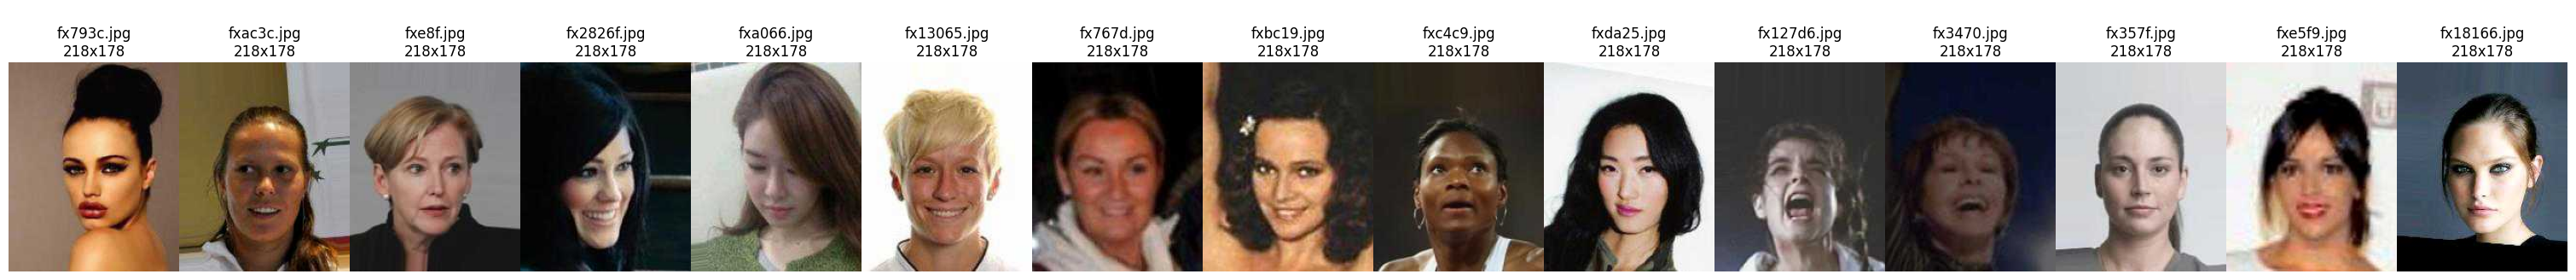

In [6]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'female/'+f);
  _ = ax.set_title(f'\n{f}\n{img.shape[0]}x{img.shape[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

Примеры изображений мужского пола

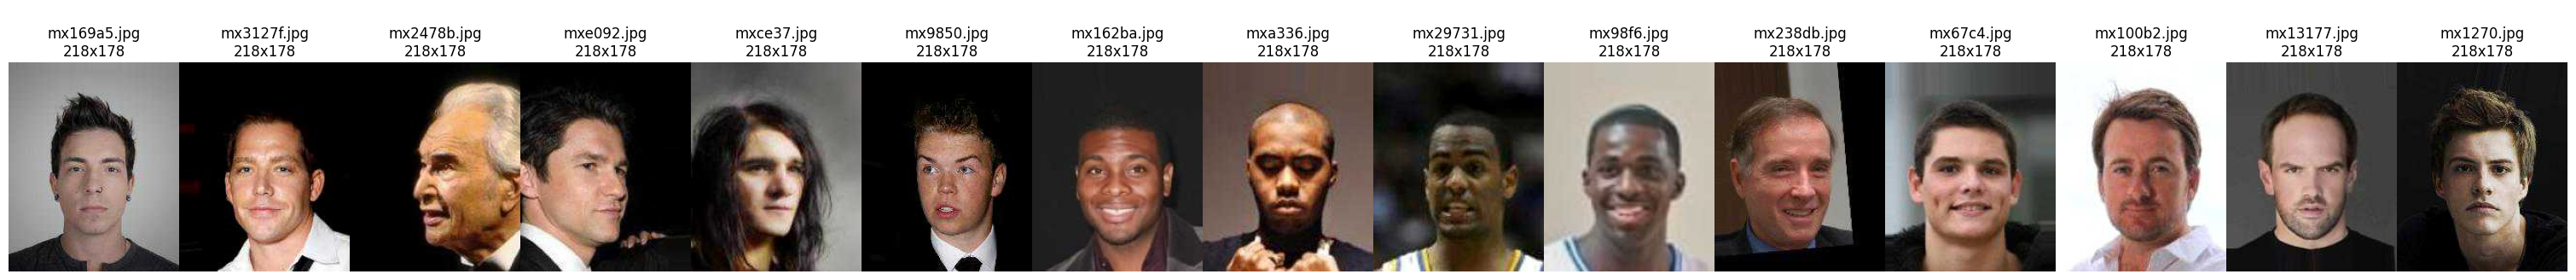

In [7]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'male/'+f);
  _ = ax.set_title(f'\n{f}\n{img.shape[0]}x{img.shape[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

<font size=5>⏳</font> <strong><font color=orange size=5>Ваш код, документация, идеи и таймер - Все это начинается здесь...</font></strong>


In [14]:
tmr = Timer()
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import os

torch.manual_seed(45)
torch.cuda.manual_seed_all(45)
np.random.seed(45)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

def create_model():
    model = torchvision.models.efficientnet_b0(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.features[-5:].parameters():
        param.requires_grad = True

    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(in_features, 1)
    )
    return model.to(device)

model = create_model()

criterion = FocalLoss(alpha=0.25, gamma=2.0)

optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], weight_decay=1e-3)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

num_epochs = 10
best_val_acc = 0.0
patience_counter = 0
patience_limit = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tDL:
        images = images.to(device)
        labels = labels.float().to(device)

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in vDL:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    train_loss /= len(tDL.dataset)
    train_acc = train_correct / train_total
    val_loss /= len(vDL.dataset)
    val_acc = val_correct / val_total

    scheduler.step(val_acc)

    print(f"Эпоха {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print(f"Ранняя остановка на эпохе {epoch+1}")
            break

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in vDL:
        images = images.to(device)
        labels = labels.float().to(device)

        outputs = model(images).squeeze()
        preds = torch.sigmoid(outputs) > 0.5
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

final_val_acc = val_correct / val_total
print(f"\nФинальная точность на валидации: {final_val_acc*100:.2f}%")

vIDs = [os.path.splitext(os.path.basename(f[0]))[0] for f in sDL.dataset.imgs]

with torch.no_grad():
    preds = []
    for img, _ in sDL:
        img = img.to(device)
        outputs = model(img).squeeze()
        batch_preds = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds.append(batch_preds)

all_preds = np.concatenate(preds, axis=0)

submission_df = pd.DataFrame({
    'id': vIDs,
    'y': (all_preds > 0.5).astype(int)
})

submission_file = '6798797.csv'
submission_df.to_csv('6798797', index=False)
print(f"Результаты сохранены в {submission_file}")
tmr.ShowTime()

⏳ начался. У вас есть 300 сек. Удачи!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 42.2MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 1: Train Acc: 0.8333, Val Acc: 0.9060


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 2: Train Acc: 0.9355, Val Acc: 0.9260


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 3: Train Acc: 0.9627, Val Acc: 0.9300


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 4: Train Acc: 0.9735, Val Acc: 0.9300


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 5: Train Acc: 0.9858, Val Acc: 0.9340


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 6: Train Acc: 0.9840, Val Acc: 0.9260


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 7: Train Acc: 0.9912, Val Acc: 0.9430


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 8: Train Acc: 0.9958, Val Acc: 0.9310


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 9: Train Acc: 0.9942, Val Acc: 0.9360


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Эпоха 10: Train Acc: 0.9942, Val Acc: 0.9400


<All keys matched successfully>

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat


Финальная точность на валидации: 94.30%
Результаты сохранены в 6798797.csv
Время выполнения 241 сек.


## **Задание 1**

**Объясните вашу предобработку данных:** например, feature engineering, subsampling, кластеризация, снижение размерности и т.д.

## **Задание 2**

**Объясните свой подход к построению модели:** идеи, которые вы попробовали, и почему вы решили, что они будут полезны. Вывод: как эти решения помогали вам в моделировании.

1)Впервую очередь я решил выбрать модель и функцию потерь для данной задачи.
Я начал с гугления "лучшие модели для классификации изобра
жений" и нашел модель EfficientNet-B0, на которой и остановился. Для функции потерь сначала взял стандартную BCEWithLogitsLoss, потому что она часто используется в бинарной классификации. Но позже эксперементируя заменил на Focal Loss, когда увидел, что точность была недосточна(86%).

*Источники:*  
[1] [EfficientNet: Rethinking Model Scaling for CNNs (официальная статья)](https://arxiv.org/abs/1905.11946)  
[2] [PyTorch Loss Functions - документация](https://pytorch.org/docs/stable/nn.html#loss-functions)

2) Далее я решил выбрать оптимизатор. На семинаре мы обсуждали Adam с него я и начал. Потом в ходе работы я поменял его на AdamW, потому что прочитал на StackOverflow, что он лучше работает с регуляризацией. Изучая архитектуру генеративного ИИ я на ткнулся на такое понятие, как планировщик.И решил тоже добавить в модель подумав, что лишним не будет чтобы автоматически уменьшать скорость обучения, когда модель перестает улучшаться(остановился на ReduceLROnPlateau).

*Источники:*  
[3] [Adam: A Method for Stochastic Optimization (оригинальная статья)](https://arxiv.org/abs/1412.6980)  
[4] [AdamW vs Adam на StackOverflow](https://stackoverflow.com/questions/64621585/adamw-and-adam-with-weight-decay)  
[5] [PyTorch Schedulers - документация](https://pytorch.org/docs/stable/optim.html)

3) Уже в общем создав работоспособную архетиктуру модели, я столкнулся с проблемой(классификация была не достаточно точной). Изучая проблемы классификационных моделей, основной была дисбаланс классов.
Погуглил и нашел два подхода(которые было не слишком сложно релизовать):  
- Взвешенная функция потерь (Focal Loss, на которую в итоге и заменил исходную)    
- Аугментация данных (добавил случайные повороты, отражения и изменения цвета)  

*Источники:*  
[6] [Methods to handle Imbalanced Data - Towards Data Science](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

4)Теперь поговорим о настройке моделей
- Замораживание слоев Взял идею из туторила PyTorch  - сначала заморозил все слои, обучал только классификатор, потом разморозил последние 5 слоев.  
- Dropout: Добавил с вероятностью 0.3, потом поменял на 0.5, чтобы борьбы с переобучением (это нам расказывали на семинаре) .  
- Разные learning rates: Сделал меньше LR для предобученных слоев (1e-4) и больше для нового классификатора (1e-3), как советовали на Kaggle(для увеличения скорости обучения).  

*Источники:*  
[7] [Transfer Learning Tutorial - PyTorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)  
[8] [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)  
[9] [Practical Tips for CNN - Kaggle Discussion](https://www.kaggle.com/discussions/general/370883)

5) Далее возникла новая проблема модель обучалась слишком долго, а терять баллы на штрафе не хотелось.
Добавил Early Stopping эпохи, чтобы не тратить время зря, когда модель перестает улучшаться. Сохранял только лучшую модель по точности на валидации.

*Источники:*  
[10] [Early Stopping - CS231n Notes](https://cs231n.github.io/neural-networks-3/#stopping)



Следующая ячейка загружает train/validation/test наборы данных как [ImageFolder datasets](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html), `tDS`, `vDS` и `sDS` соответственно.

In [8]:
BS, image_size = 32, (224, 224)
transform = v2.Compose([v2.ToTensor(), v2.Resize(image_size, antialias=True)])

In [9]:
!mv test/ labels/ && mkdir test && mv labels/ test/labels/

In [10]:
im_folder_train = ImageFolder(tDIR, transform=transform)
im_folder_test = ImageFolder(sDIR, transform=transform)

In [11]:
tDS, vDS = random_split(im_folder_train, lengths=[0.8, 0.2])

In [12]:
tDL = DataLoader(tDS, batch_size=BS, shuffle=True, pin_memory=True)
vDL = DataLoader(vDS, batch_size=BS, shuffle=False, pin_memory=True)
sDL = DataLoader(im_folder_test, batch_size=BS, shuffle=False, pin_memory=True)

In [13]:
print(f"Train size: {len(tDS)}")
print(f"Val size: {len(vDS)}")
print(f"Test size: {len(sDL)}")
print(next(iter(tDL))[0][:10].sum())  # для проверки правильности заполнения выборки файлов

Train size: 4000
Val size: 1000
Test size: 157
tensor(496284.4375)


Это ваша базовая модель DNN. Не забудьте [зафиксировать seed во всех своих экспериментах](https://pytorch.org/docs/stable/notes/randomness.html#reproducibility) для воспроизводимости.

Ниже мы заменяем верхний слой предварительно подготовленного CNN ([MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)) и обучаем только новый слой (все оставшиеся предобученные слои замораживаются).

In [ ]:
%%time
torch.manual_seed(0)  # всегда ставьте seed в ваших экспериментах
torch.cuda.manual_seed_all(0)  # ставьте seed везде, где только можно

CPU times: user 1.63 ms, sys: 0 ns, total: 1.63 ms
Wall time: 1.71 ms


In [ ]:
pm = mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)  # предобученная модель mobile_net

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 171MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
pm1 = Sequential(
    pm,
    LazyLinear(1)
)

In [ ]:
for l in pm1[0].parameters(): l.requires_grad = False  # замораживание слоев, чтобы не было обучения
sgd = torch.optim.SGD(pm1.parameters(), lr=0.2, momentum=0.9, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(sgd, gamma=0.01)
criterion = nn.BCEWithLogitsLoss()
pm1 = pm1.to(device)

In [ ]:
def trainer(model, epoch=2, validate=True):
  losses = []

  for e in range(epoch):
    print(f"Epoch: {e}")
    model.train()
    for i, (image, label) in enumerate(tDL):


      image = image.to(device)
      label = label.to(device).type(torch.float32)
      sgd.zero_grad()
      pred = model(image)
      loss = criterion(pred, label.unsqueeze(1))
      losses.append(loss)

      if i % 10 == 0:
        print(loss)

      loss.backward()
      sgd.step()
      scheduler.step()

    if validate:
      model.eval()

      s = 0
      for i, (image, label) in enumerate(vDL):
        image = image.to(device)
        label = label.to(device).type(torch.float32)
        with torch.no_grad():
          val_preds = nn.functional.sigmoid(model(image))
          s += ((val_preds > 0.5).type(torch.int) == label.unsqueeze(1)).sum()

      print(f"Acc: {s / (len(vDL) * BS)}")

  return losses

In [ ]:
%%time
hist = trainer(pm1)

Epoch: 0
tensor(0.7283, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.7114, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.3121, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6092, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9822, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9383, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1337, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.7018, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5816, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.1613, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.7804, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.8092, device='

Ниже мы проведем последующее обучение всех предварительно подготовленных слоев после их разблокировки.

In [ ]:
for l in pm1[0].parameters(): l.requires_grad = True  # разморозка слоев для обучения
sgd = torch.optim.SGD(pm1.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(sgd, gamma=0.001)

In [ ]:
%%time
hist_trainable = trainer(pm1)

Epoch: 0
tensor(0.8359, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.7262, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9411, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9972, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9045, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9437, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.8673, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9741, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.9393, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.8640, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6725, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.7385, device='

Составление и экспорт прогнозов:

In [ ]:
vIDs = [f[0].split('/')[-1].split('.')[0] for f in sDL.dataset.imgs] # извлечение ID изображений из имен файлов

In [ ]:
with torch.no_grad():
    preds = []
    for img, _ in sDL:
        preds.append(nn.functional.sigmoid(pm1(img.to(device))).cpu().numpy().flatten())

In [ ]:
pY = pd.DataFrame(np.concatenate(preds, axis=0), index=vIDs, columns=['y'])   # предсказанные таргеты
ToCSV((pY>0.5)*1, '🪐-baseline')

# **Ссылки на источники:**

1. Не забудьте указать свои источники здесь! Google Scholar позволяет вам без особых усилий копировать/вставлять ссылки на книги и публикации в стиле APA. Также цитируйте StackOverflow, документацию по пакетам и другие значимые интернет-ресурсы, чтобы избежать обвинений в плагиате.

<font size=5>⏳</font> <strong><font color=orange size=5>Не превышайте лимит времени выполнения решения соревнования!</font></strong>


In [ ]:
tmr.ShowTime()    # измерьте время работы Colab. Не удаляйте. Сохраните в качестве последней ячейки в своем ноутбуке

Время выполнения 231 сек.


## 💡**Стартовые идеи**

1. Попробуйте настроить гиперпараметры и архитектуру CNN
1. Другие [предобученные модели](https://www.tensorflow.org/api_docs/python/tf/keras/applications) могут быть быстрее или точнее для данного набора данных и/или аппаратного обеспечения ([benchmarks](https://datascience.stackexchange.com/a/39211/14094))
1. Преобразование изображений с помощью [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) могло бы быть быстрее
1. Выявляйте плохо предсказанные изображения на трейне (с почти абсолютной достоверностью) и добавляйте их аугментации
1. Идентифицируйте плохо предсказанные тестовые изображения (с почти нулевой достоверностью) и еще больше сравнивайте CNN после обучения с "похожими" изображениями на трейне. Сходство может быть достигнуто с точки зрения некоторых слоев CNN.
1. Вам действительно нужны все приведенные изображения? CNN будет быстрее обучаться на "значимой" подвыборке
1. Попробуйте объединить различные предобученные CNN или только их выбранные слои
1. Попробуйте использовать разный шаг обучения для разных слоев предобученных моделей
1. Попробуйте обрезать изображения, а не изменять их размер до фиксированного $224\times224$ (лица выглядят более естественно, если соблюдается соотношение сторон)
1. Попробуйте [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) в Colab. 😮 Посмотрите [документацию](https://www.tensorflow.org/guide/tpu). Локальные изображения должны быть загружены с [Python I/O](https://stackoverflow.com/a/63147614/3043335), не TF datasets.